In [9]:
from utils.fastf1_api import F1DataProcessor

%load_ext autoreload
%autoreload 2

In [6]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_qualifying_laps(telemetry_data):
    """
    Analyze F1 qualifying lap telemetry data using PCA and Factor Analysis.
    
    Parameters:
    telemetry_data (pd.DataFrame): DataFrame with columns for different telemetry metrics
                                  (speed, throttle, brake, gear, etc.) and driver information
    
    Returns:
    dict: Dictionary containing analysis results and transformed data
    """
    # Separate features and metadata
    feature_cols = ['speed', 'throttle', 'brake', 'gear', 'rpm']  # Adjust based on available metrics
    X = telemetry_data[feature_cols]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    n_components = min(len(feature_cols), 3)  # Reduce to 3 components or fewer
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Perform Factor Analysis
    fa = FactorAnalysis(n_components=n_components, random_state=42)
    X_fa = fa.fit_transform(X_scaled)
    
    # Calculate explained variance for PCA
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: PCA explained variance
    plt.subplot(231)
    plt.plot(range(1, n_components + 1), cumulative_variance_ratio, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    
    # Plot 2: Feature loadings heatmap for PCA
    plt.subplot(232)
    loadings_pca = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_cols
    )
    sns.heatmap(loadings_pca, cmap='RdBu', center=0, annot=True)
    plt.title('PCA Feature Loadings')
    
    # Plot 3: Feature loadings heatmap for FA
    plt.subplot(233)
    loadings_fa = pd.DataFrame(
        fa.components_.T,
        columns=[f'Factor{i+1}' for i in range(n_components)],
        index=feature_cols
    )
    sns.heatmap(loadings_fa, cmap='RdBu', center=0, annot=True)
    plt.title('Factor Analysis Loadings')
    
    # Plot 4: Driver comparison in PCA space
    plt.subplot(234)
    for driver in telemetry_data['driver'].unique():
        mask = telemetry_data['driver'] == driver
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=driver, alpha=0.6)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Driver Comparison in PCA Space')
    plt.legend()
    
    # Plot 5: Driver comparison in FA space
    plt.subplot(235)
    for driver in telemetry_data['driver'].unique():
        mask = telemetry_data['driver'] == driver
        plt.scatter(X_fa[mask, 0], X_fa[mask, 1], label=driver, alpha=0.6)
    plt.xlabel('First Factor')
    plt.ylabel('Second Factor')
    plt.title('Driver Comparison in FA Space')
    plt.legend()
    
    # Plot 6: Feature correlations
    plt.subplot(236)
    correlations = pd.DataFrame(X_scaled, columns=feature_cols).corr()
    sns.heatmap(correlations, cmap='RdBu', center=0, annot=True)
    plt.title('Feature Correlations')
    
    plt.tight_layout()
    
    # Calculate driver statistics in reduced spaces
    def create_driver_summary(transformed_data, prefix='PC'):
        driver_summaries = []
        for driver in telemetry_data['driver'].unique():
            driver_mask = telemetry_data['driver'] == driver
            driver_data = transformed_data[driver_mask]
            
            # Calculate basic statistics
            summary = {
                'driver': driver,
                f'{prefix}1_mean': np.mean(driver_data[:, 0]),
                f'{prefix}2_mean': np.mean(driver_data[:, 1]),
                f'{prefix}1_std': np.std(driver_data[:, 0]),
                f'{prefix}2_std': np.std(driver_data[:, 1]),
                # Add consistency metrics
                f'{prefix}1_range': np.ptp(driver_data[:, 0]),
                f'{prefix}2_range': np.ptp(driver_data[:, 1]),
                # Add percentiles for more detailed distribution analysis
                f'{prefix}1_25th': np.percentile(driver_data[:, 0], 25),
                f'{prefix}1_75th': np.percentile(driver_data[:, 0], 75),
                f'{prefix}2_25th': np.percentile(driver_data[:, 1], 25),
                f'{prefix}2_75th': np.percentile(driver_data[:, 1], 75)
            }
            driver_summaries.append(summary)
        return pd.DataFrame(driver_summaries)
    
    pca_summary = create_driver_summary(X_pca, 'PC')
    fa_summary = create_driver_summary(X_fa, 'Factor')
    
    # Calculate feature importance scores
    feature_importance_pca = pd.DataFrame({
        'feature': feature_cols,
        'importance': np.abs(pca.components_[0])  # Using first principal component
    }).sort_values('importance', ascending=False)
    
    return {
        'pca_transformed': X_pca,
        'fa_transformed': X_fa,
        'explained_variance_ratio': explained_variance_ratio,
        'pca_loadings': loadings_pca,
        'fa_loadings': loadings_fa,
        'pca_summary': pca_summary,
        'fa_summary': fa_summary,
        'feature_importance': feature_importance_pca,
        'correlations': correlations,
        'figure': fig
    }

In [8]:
sample_data

,driver,speed,throttle,brake,gear,rpm
0,VER,225.503480,72.941703,19.270268,5,10360.609095
1,HAM,232.960319,67.088195,47.548499,6,9648.249774
2,LEC,236.283689,61.020661,86.535992,5,9414.950089
3,VER,208.530457,35.637953,56.193637,6,8761.893165
4,HAM,181.824556,18.433264,99.917017,6,9731.803435
...,...,...,...,...,...,...
295,HAM,245.735879,57.655830,16.229435,5,12318.374429
296,LEC,216.870891,37.796991,47.380796,1,11008.289618
297,VER,169.979925,65.748007,43.211096,2,10104.144383
298,HAM,194.180831,83.593343,94.081638,4,8756.382205


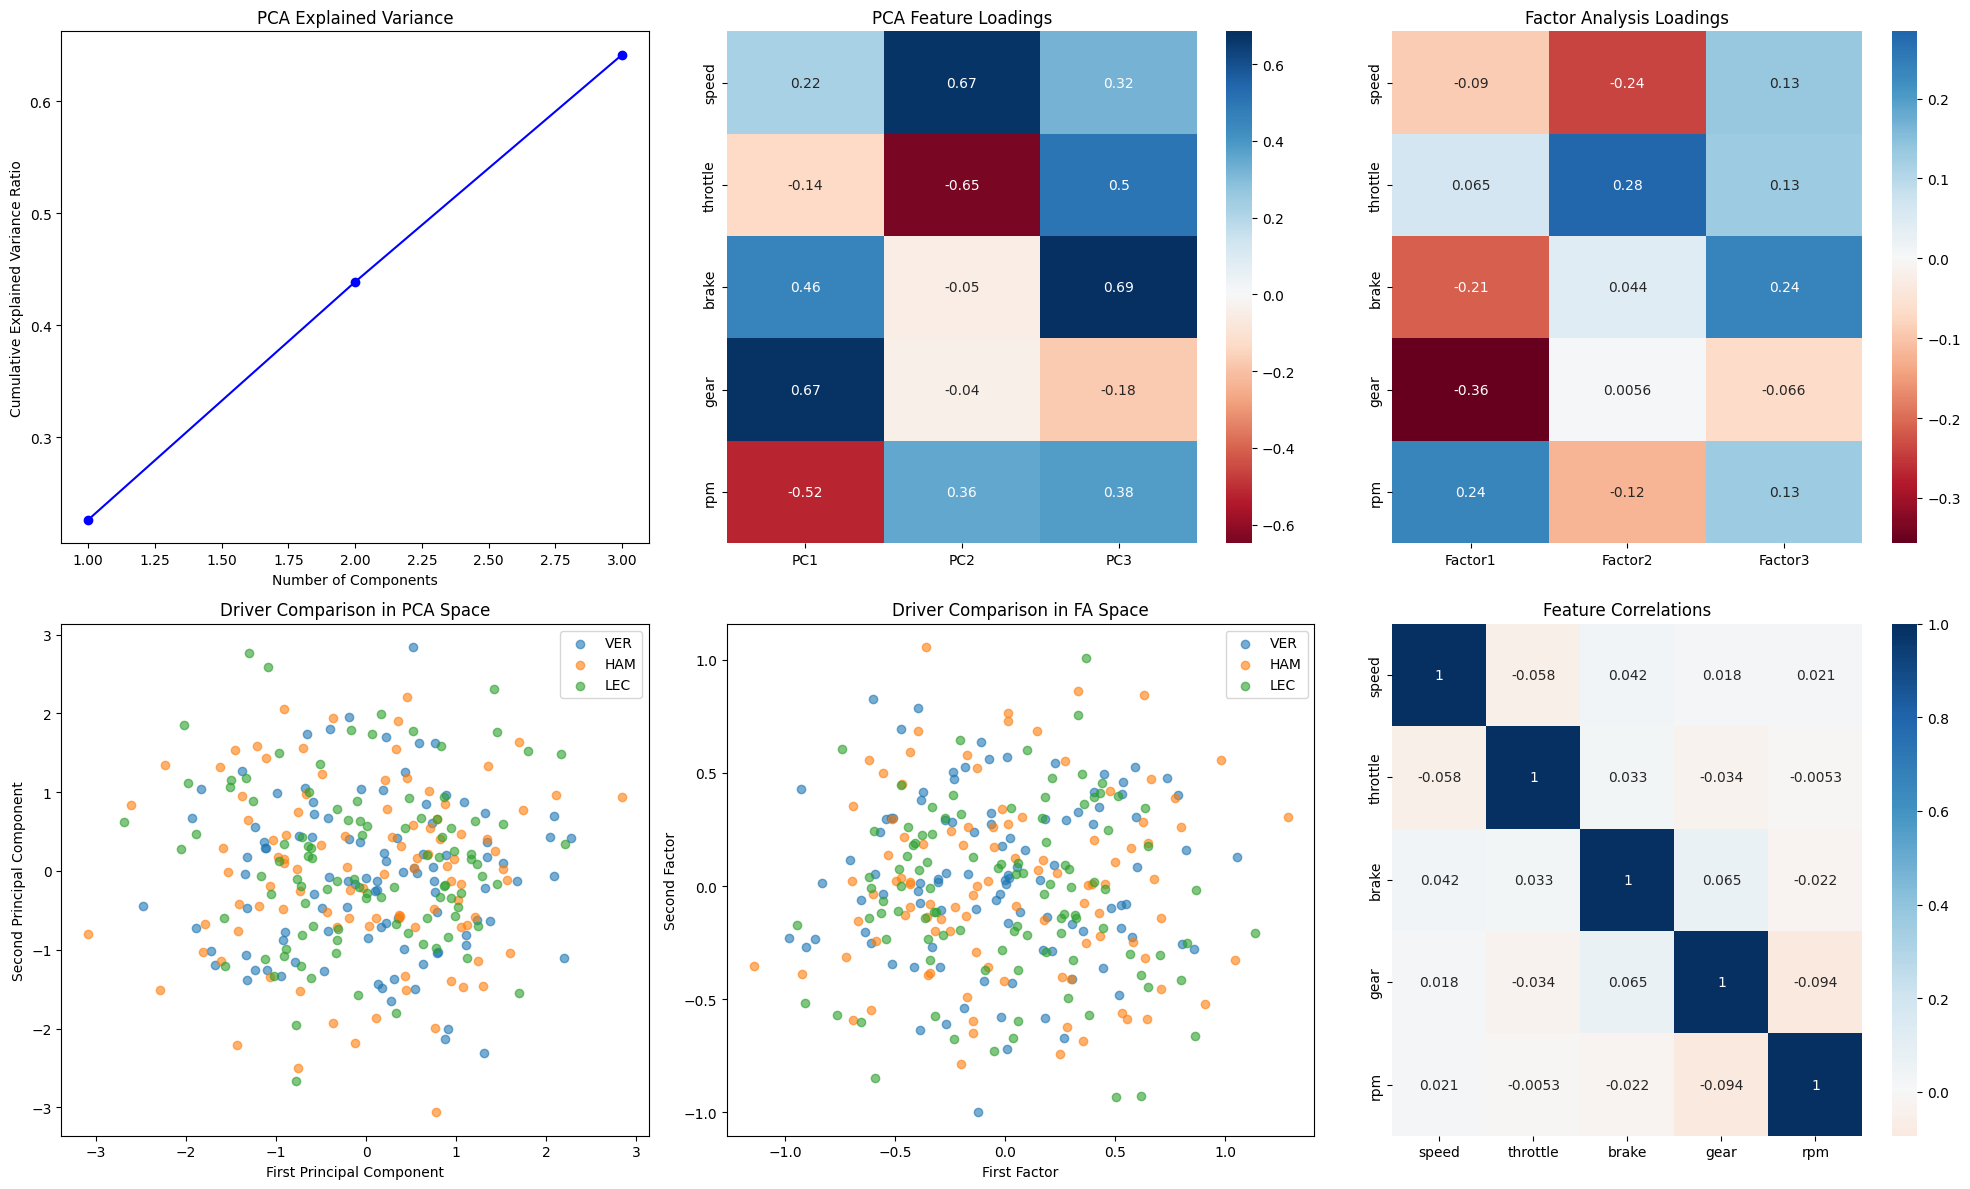

In [7]:
sample_data = pd.DataFrame({
    'driver': ['VER', 'HAM', 'LEC'] * 100,
    'speed': np.random.normal(200, 20, 300),
    'throttle': np.random.uniform(0, 100, 300),
    'brake': np.random.uniform(0, 100, 300),
    'gear': np.random.randint(1, 8, 300),
    'rpm': np.random.normal(10000, 1000, 300),
})

results = analyze_qualifying_laps(sample_data)

In [15]:
f1_processor = F1DataProcessor("cache", 2024)

quali_df = f1_processor.get_quali_session([5])

core           INFO 	Loading data for Chinese Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '4', '81', '16', '55', '63', '27', '77', '18', '3', '31', '23', '10', '24', '20', '44', '22', '2']
/Users/katecastillo/Documents/learning/f1-exploration/utils/fastf1_api.py:59: SettingWithCopyWarning: 
A valu

In [16]:
quali_df

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance,Lap,CumulativeDistance,Driver
0,2024-04-20 07:06:19.185,11007,279,7,100,0,12,car,0 days 00:00:00.257000,0 days 00:17:15.181000,19.917500,1,0.000000,VER
1,2024-04-20 07:06:19.345,11115,280,7,100,0,12,car,0 days 00:00:00.417000,0 days 00:17:15.341000,32.361944,1,12.444444,VER
2,2024-04-20 07:06:19.545,11202,282,7,100,0,12,car,0 days 00:00:00.617000,0 days 00:17:15.541000,48.028611,1,40.555556,VER
3,2024-04-20 07:06:19.745,11279,285,7,100,0,12,car,0 days 00:00:00.817000,0 days 00:17:15.741000,63.861944,1,84.500000,VER
4,2024-04-20 07:06:20.066,11393,289,7,100,0,12,car,0 days 00:00:01.138000,0 days 00:17:16.062000,89.631111,1,154.213611,VER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33639,2024-04-20 07:09:07.986,10671,247,7,100,0,12,car,0 days 00:01:34.969000,0 days 00:20:03.982000,5316.615833,1,932398.752500,SAR
33640,2024-04-20 07:09:08.266,10470,253,7,100,0,12,car,0 days 00:01:35.249000,0 days 00:20:04.262000,5336.293611,1,937725.084444,SAR
33641,2024-04-20 07:09:08.546,10687,260,7,100,0,12,car,0 days 00:01:35.529000,0 days 00:20:04.542000,5356.515833,1,943071.638611,SAR
33642,2024-04-20 07:09:08.866,10959,265,7,100,0,12,car,0 days 00:01:35.849000,0 days 00:20:04.862000,5380.071389,1,948441.748333,SAR


In [17]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 3.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [21]:
!pip install numpy==2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 3.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [23]:
!pip install fastdtw

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3565 sha256=ef5bf719d92e3008df2dff7b54a2df8c914492e6c66162932cb8b0c74de902b5
  Stored in directory: /Users/katecastillo/Library/Caches/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.matrix_profile import MatrixProfile
from tslearn.piecewise import SymbolicAggregateApproximation
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.signal import resample
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

@dataclass
class F1TelemetryAnalyzer:
    sampling_rate = 100
    sax = SymbolicAggregateApproximation(n_segments=10, alphabet_size_avg=8)
        
    def preprocess_lap_data(self, telemetry_data, lap_column='lap', time_column='time'):
        """
        Preprocess telemetry data by aligning and resampling lap data
        
        Parameters:
        telemetry_data (pd.DataFrame): DataFrame with columns for telemetry metrics,
                                     lap numbers, and timestamps
        """
        feature_cols = ['speed', 'throttle', 'brake', 'gear', 'rpm', 'drs']
        
        # Group data by lap and driver
        grouped = telemetry_data.groupby(['driver', lap_column])
        
        processed_laps = []
        lap_metrics = []
        
        for (driver, lap), lap_data in grouped:
            # Sort by timestamp
            lap_data = lap_data.sort_values(time_column)
            
            # Calculate lap duration
            lap_duration = (lap_data[time_column].max() - 
                          lap_data[time_column].min()).total_seconds()
            
            # Resample to fixed number of points
            n_points = int(lap_duration * self.sampling_rate)
            resampled_data = {}
            
            for feature in feature_cols:
                if feature in lap_data.columns:
                    # Resample the feature data
                    resampled = resample(lap_data[feature], n_points)
                    resampled_data[feature] = resampled
            
            # Store processed data
            resampled_df = pd.DataFrame(resampled_data)
            resampled_df['driver'] = driver
            resampled_df['lap'] = lap
            resampled_df['normalized_time'] = np.linspace(0, 1, n_points)
            
            processed_laps.append(resampled_df)
            
            # Calculate lap metrics
            metrics = {
                'driver': driver,
                'lap': lap,
                'duration': lap_duration,
                'max_speed': lap_data['speed'].max(),
                'avg_speed': lap_data['speed'].mean(),
                'brake_applications': len(lap_data[lap_data['brake'] > 0]),
                'drs_zones': len(lap_data[lap_data['drs'] > 0])
            }
            lap_metrics.append(metrics)
            
        return pd.concat(processed_laps), pd.DataFrame(lap_metrics)

    def calculate_dtw_distances(self, processed_data, feature='speed'):
        """
        Calculate DTW distances between all laps for a specific feature
        """
        drivers = processed_data['driver'].unique()
        dtw_matrix = np.zeros((len(drivers), len(drivers)))
        
        for i, driver1 in enumerate(drivers):
            for j, driver2 in enumerate(drivers):
                if i <= j:
                    series1 = processed_data[processed_data['driver'] == driver1][feature].values
                    series2 = processed_data[processed_data['driver'] == driver2][feature].values
                    distance = dtw.distance(series1, series2)
                    dtw_matrix[i, j] = distance
                    dtw_matrix[j, i] = distance
                    
        return pd.DataFrame(dtw_matrix, index=drivers, columns=drivers)

    def find_distinctive_segments(self, processed_data, feature='speed'):
        """
        Find distinctive segments in lap data using Matrix Profile
        """
        mp = MatrixProfile(window_size=int(self.sampling_rate))
        matrix_profile = mp.fit_transform(processed_data[feature].values.reshape(1, -1))
        
        return matrix_profile

    def analyze_laps(self, telemetry_data):
        """
        Perform comprehensive analysis of lap telemetry data
        """
        # Preprocess the data
        processed_data, lap_metrics = self.preprocess_lap_data(telemetry_data)
        
        # Calculate DTW distances for speed profiles
        dtw_distances = self.calculate_dtw_distances(processed_data, 'speed')
        
        # Perform dimensionality reduction on the processed data
        feature_cols = ['speed', 'throttle', 'brake', 'gear', 'rpm', 'drs']
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(processed_data[feature_cols])
        
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X_scaled)
        
        # Create visualizations
        fig = plt.figure(figsize=(20, 12))
        
        # Plot 1: Speed profiles
        plt.subplot(231)
        for driver in processed_data['driver'].unique():
            driver_data = processed_data[processed_data['driver'] == driver]
            plt.plot(driver_data['normalized_time'], 
                    driver_data['speed'], 
                    label=driver, alpha=0.7)
        plt.xlabel('Normalized Lap Time')
        plt.ylabel('Speed')
        plt.title('Speed Profiles')
        plt.legend()
        
        # Plot 2: DTW distances heatmap
        plt.subplot(232)
        sns.heatmap(dtw_distances, annot=True, cmap='YlOrRd')
        plt.title('DTW Distances Between Drivers')
        
        # Plot 3: PCA of full telemetry
        plt.subplot(233)
        for driver in processed_data['driver'].unique():
            mask = processed_data['driver'] == driver
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       label=driver, alpha=0.6)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('PCA of Telemetry Data')
        plt.legend()
        
        # Plot 4: Throttle vs Brake patterns
        plt.subplot(234)
        for driver in processed_data['driver'].unique():
            driver_data = processed_data[processed_data['driver'] == driver]
            plt.scatter(driver_data['throttle'], 
                       driver_data['brake'], 
                       label=driver, alpha=0.3)
        plt.xlabel('Throttle')
        plt.ylabel('Brake')
        plt.title('Throttle vs Brake Patterns')
        plt.legend()
        
        # Plot 5: Lap time distributions
        plt.subplot(235)
        sns.boxplot(data=lap_metrics, x='driver', y='duration')
        plt.title('Lap Time Distributions')
        plt.xticks(rotation=45)
        
        # Plot 6: Feature correlations over time
        plt.subplot(236)
        correlations = processed_data[feature_cols].corr()
        sns.heatmap(correlations, cmap='RdBu', center=0, annot=True)
        plt.title('Feature Correlations')
        
        plt.tight_layout()
        
        return {
            'processed_data': processed_data,
            'lap_metrics': lap_metrics,
            'dtw_distances': dtw_distances,
            'pca_transformed': X_pca,
            'pca_explained_variance': pca.explained_variance_ratio_,
            'figure': fig
        }

[autoreload of numpy._core.multiarray failed: Traceback (most recent call last):
  File "/Users/katecastillo/Documents/learning/f1-exploration/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/katecastillo/Documents/learning/f1-exploration/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/katecastillo/.pyenv/versions/3.11.9/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/katecastillo/Documents/learning/f1-exploration/.venv/lib/python3.11/site-packages/numpy/_core/multiarray.py", line 83, in <module>
    @ar

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.